In [ ]:
import requests
import numpy as np
import pandas as pd
import time
import re
from bs4 import BeautifulSoup
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# **Gathering data for product A maggie 12 pack**

In [ ]:
# Product A = 12 pack maggie

# Using requests library to get the diffrent dates HTML pages from the wayback machine

url='http://web.archive.org/cdx/search/cdx'
target='www.amazon.in/dp/B07B4KQRZG*'

try :
  response=requests.get(url,params={'url':target,
                                    'output':'json',
                                    'filter':'statuscode:200',
                                    'fl':'original,timestamp',
                                    'collapse':'timestamp:6'},timeout=20)
  response.raise_for_status()
  a_raw_data=response.json()
  print(type(a_raw_data))

except requests.exceptions.RequestException as e:
  print(e)


<class 'list'>


In [ ]:
# converting list of HTML pages to the dataframe


a_raw_df=pd.DataFrame(a_raw_data[1:],columns=a_raw_data[0])

# adding record date column as datatype datetime & drop dublicate values & other operations
a_raw_df['record_date']=pd.to_datetime(a_raw_df['timestamp'].to_list(),format='%Y%m%d%H%M%S').date
a_raw_df.drop_duplicates(subset=['record_date'],inplace=True)
a_raw_df.sort_values(by='record_date',inplace=True)
a_raw_df.reset_index(inplace=True,drop=True)

# making url like this : https://web.archive.org/web/ + timestamp + / + original_url.
a_raw_df['webpages']='https://web.archive.org/web/'+a_raw_df['timestamp']+'/'+a_raw_df['original']



a_raw_df.head()


,original,timestamp,record_date,webpages
0,https://www.amazon.in/dp/B07B4KQRZG/ref=tsm_1_...,20200927105230,2020-09-27,https://web.archive.org/web/20200927105230/htt...
1,https://www.amazon.in/dp/B07B4KQRZG/ref=as_li_...,20201031235930,2020-10-31,https://web.archive.org/web/20201031235930/htt...
2,https://www.amazon.in/dp/B07B4KQRZG/ref=as_li_...,20201101202316,2020-11-01,https://web.archive.org/web/20201101202316/htt...
3,https://www.amazon.in/dp/B07B4KQRZG/ref=as_li_...,20201102051918,2020-11-02,https://web.archive.org/web/20201102051918/htt...
4,https://www.amazon.in/dp/B07B4KQRZG,20201105181717,2020-11-05,https://web.archive.org/web/20201105181717/htt...


In [ ]:
# function will take url and return the title and price from the html page

def parse_page(webpage_link):

  from bs4 import BeautifulSoup
  result={'title':None,'price':None}
  time.sleep(10)
  try:
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
    response=requests.get(webpage_link,timeout=20,headers=headers)
    html=response.content
    soup=BeautifulSoup(html,'html.parser')

    if soup.find(id='productTitle') is None:
      result['title']=None
    else:
      webpage_title=soup.find(id='productTitle').get_text().strip()
      result['title']=webpage_title


    if soup.find('span',{'class':"a-price-whole"}) is not None:
      webpage_price=soup.find('span',{'class':"a-price-whole"}).get_text().strip()

    elif soup.find(id='priceblock_dealprice') is not None:
      webpage_price=soup.find(id='priceblock_dealprice').get_text().strip()

    elif soup.find(id='priceblock_ourprice') is not None:
      webpage_price=soup.find(id='priceblock_ourprice').get_text().strip()

    else:
      webpage_price=None

    if webpage_price is not None:
      webpage_final_price=re.sub(r'[^\d.]','',webpage_price)
      result['price']=float(webpage_final_price)

    else:
      result['price']=webpage_price

    return result

  except Exception as e:
    print(e)



In [ ]:
# !! Need to run this cell if you want the scraped_data.I have saved the data as scraped_data (df) and loaded

# a_scraped_df=a_raw_df['webpages'].apply(parse_page)
## a_scraped_df=a_scraped_df.apply(pd.Series)
## a_scraped_df.to_csv('a_scraped_data')

# loading scraped data from the disk (You may need to change the path based on your file location)
a_scraped_df=pd.read_csv('/content/a_scraped_data')
a_scraped_df=a_scraped_df.drop("Unnamed: 0",axis=1)
a_scraped_df.head()

,title,price
0,"Maggi 2-Minute Noodles Masala, 70g (Pack of 12)",144.0
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,"Maggi 2-Minute Noodles Masala, 70g (Pack of 12)",129.6


In [ ]:
# concatanating raw_df & scraped_data(df) & droping null values

a_concat_df=pd.concat([a_raw_df,a_scraped_df],axis=1)
a_concat_df.dropna(inplace=True)
a_concat_df.reset_index(inplace=True,drop=True)
a_concat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   original     169 non-null    object 
 1   timestamp    169 non-null    object 
 2   record_date  169 non-null    object 
 3   webpages     169 non-null    object 
 4   title        169 non-null    object 
 5   price        169 non-null    float64
dtypes: float64(1), object(5)
memory usage: 8.1+ KB


In [ ]:
# this function extract weight,unit and no of packs from the title

def extract_product_details(title_text):

  result={}
  if title_text is not None:

    no_of_packs=1
    grps=re.search(r'Pack of\s+(\d+)',title_text,flags=re.IGNORECASE)
    if grps:
      no_of_packs=int(grps.group(1))
      result['no_of_packs']=no_of_packs

    grps2=re.search(r'(\d*\.?\d+)\s*(g|kg|gm|gram|ml|l)',title_text,flags=re.IGNORECASE)
    if grps2:
      weight_per_pack=float(grps2.group(1))
      unit=grps2.group(2)
      result['weight_per_pack']=weight_per_pack
      result['unit']=unit
      if weight_per_pack>100 :
        total_weight=weight_per_pack
      else:
        total_weight=weight_per_pack*no_of_packs

      result['total_weight']=total_weight

    return result
  else :
    result={'weight_per_pack':None,'unit':None,'no_of_packs':None,'total_weight':None}
    return result

In [ ]:
# extracting the information from the
a_information_df=a_concat_df['title'].apply(extract_product_details).apply(pd.Series)
print(a_information_df['unit'].unique())

['g' 'G']


In [ ]:
# concatinating a_raw_df and a_information_df
a_all_df=pd.concat([a_concat_df,a_information_df],axis=1)

# calculating price per 100g
a_all_df['price_per_100g']=(a_all_df['price']/a_all_df['total_weight'])*100

# **Saving data to the database using sqlite3**

In [ ]:
# making connection and cursor for further workflow

con=sqlite3.connect('shrinkflation.db')
cur=con.cursor()

In [ ]:
# Creating tables - products , price_history
cur.execute("""create table  if not exists
               products(product_id integer primary key autoincrement,
               product_name text,
               base_currency text)""",)

cur.execute("""create table  if not exists
               price_history(record_id integer primary key autoincrement,
               product_id integer,
               record_date text,
               price real,
               weight_grams real,
               unit_price real,
               foreign key(product_id) references products(product_id))""")

cur.execute("""create table if not exists
              economic_indicators(record_date text primary key,
              general_cpi real,
              food_cpi real)""")

# confirming the table is created
res=cur.execute('select name from sqlite_master where type="table"')
res.fetchall()

[('products',),
 ('sqlite_sequence',),
 ('price_history',),
 ('economic_indicators',)]

In [ ]:
# adding products details to the products tabel
cur.execute("""insert into products (product_name,base_currency) values
                ('Maggi 2-Minute Noodles Masala (Pack of 12)','INR')""")


# comitining...
con.commit()

# confirming
res=cur.execute('select * from products')
res.fetchall()

[(1, 'Maggi 2-Minute Noodles Masala (Pack of 12)', 'INR')]

In [ ]:
# making df for a to add the data to the database

# maching names with table
a_sql_df=a_all_df.rename(columns={'total_weight':'weight_grams',
                          'price_per_100g':'unit_price'},)
# adding foreginkey column
a_sql_df['product_id']=1
# droping unnecery columns
a_sql_df=a_sql_df.drop(['original','timestamp','webpages','title','no_of_packs','weight_per_pack','unit'],axis=1)
a_sql_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   record_date   169 non-null    object 
 1   price         169 non-null    float64
 2   weight_grams  169 non-null    float64
 3   unit_price    169 non-null    float64
 4   product_id    169 non-null    int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 6.7+ KB


In [ ]:
# making df to add in database
# General index & Consumer food price index downloaded from https://cpi.mospi.gov.in
general_index_df=pd.read_csv('General_Index_Sep20-To-Oct25.csv',header=1)
food_price_index_df=pd.read_csv('Food_Price_Index_Sep20-To-Oct25 .csv',header=1)

# cleaning both df and removing the unnecery stuffs
general_index_df['Year']=general_index_df['Year'].astype('str')
general_index_df['Date']=general_index_df['Month']+'-'+general_index_df['Year']
general_index_df['Date']=general_index_df['Date'].apply(lambda x:pd.to_datetime(x,format='%B-%Y')).astype('str')
general_index_df=general_index_df.drop(columns=['State','Group','Sub Group','Description','Rural','Urban','Status','Month','Year','Unnamed: 10'])

food_price_index_df['Year']=food_price_index_df['Year'].astype('str')
food_price_index_df['Date']=food_price_index_df['Month']+'-'+food_price_index_df['Year']
food_price_index_df['Date']=food_price_index_df['Date'].apply(lambda x:pd.to_datetime(x,format='%B-%Y')).astype('str')
food_price_index_df=food_price_index_df.drop(columns=['State','Group','Sub Group','Description','Rural','Urban','Status','Month','Year','Unnamed: 10'])

# renaming columns
general_index_df.rename(columns={'Combined':'general_cpi','Date':'record_date'},inplace=True)
food_price_index_df.rename(columns={'Combined':'food_cpi','Date':'record_date'},inplace=True)

# concating
cpi_df=pd.merge(general_index_df,food_price_index_df,on='record_date')
cpi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   general_cpi  62 non-null     float64
 1   record_date  62 non-null     object 
 2   food_cpi     62 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.6+ KB


In [ ]:
# adding product a df to the database
a_sql_df.to_sql(name='price_history',con=con,if_exists='append',index=False,method='multi')
# confirming..
res=cur.execute('select count(*) from price_history' )
print('price_history :',res.fetchone())

# adding cpi data to the table
cpi_df.to_sql('economic_indicators',con=con,if_exists='append',index=False,method='multi')
# confirming..
res=cur.execute('select count(*) from economic_indicators')
print('economic_indicators :',res.fetchone())

price_history : (169,)
economic_indicators : (62,)


# **Visualization**

In [ ]:
# fetching the required columns from database for product a and calculating

final_df=pd.read_sql(""" with a_price as
                (select strftime('%Y-%m-01',record_date) as date,
                avg(unit_price) as avg_price
                from price_history group by date)

                select a.date,avg_price,e.general_cpi,e.food_cpi from a_price a
                inner join economic_indicators e on a.date=e.record_date
                """,con=con)

# doing neccery operations on final_df
final_df['date']=final_df['date'].apply(lambda x : pd.to_datetime(x,format='%Y-%m-%d'))
final_df.sort_values(by='date',inplace=True)

# normalization
start_price=final_df['avg_price'][0]
start_food_cpi=final_df['food_cpi'][0]
start_general_cpi=final_df['general_cpi'][0]

final_df['maggie_index']=(final_df['avg_price']/start_price)*100
final_df['food_cpi_index']=(final_df['food_cpi']/start_food_cpi)*100
final_df['inflation_index']=(final_df['general_cpi']/start_general_cpi)*100
final_df.head()

,date,avg_price,general_cpi,food_cpi,maggie_index,food_cpi_index,inflation_index
0,2020-09-01,17.142857,156.4,161.6,100.000000,100.000000,100.000000
1,2020-11-01,15.771429,158.9,166.0,92.000000,102.722772,101.598465
2,2020-12-01,15.428571,157.3,160.6,90.000000,99.381188,100.575448
3,2021-01-01,15.357143,156.3,156.4,89.583333,96.782178,99.936061
4,2021-02-01,15.952381,156.6,155.5,93.055556,96.225248,100.127877


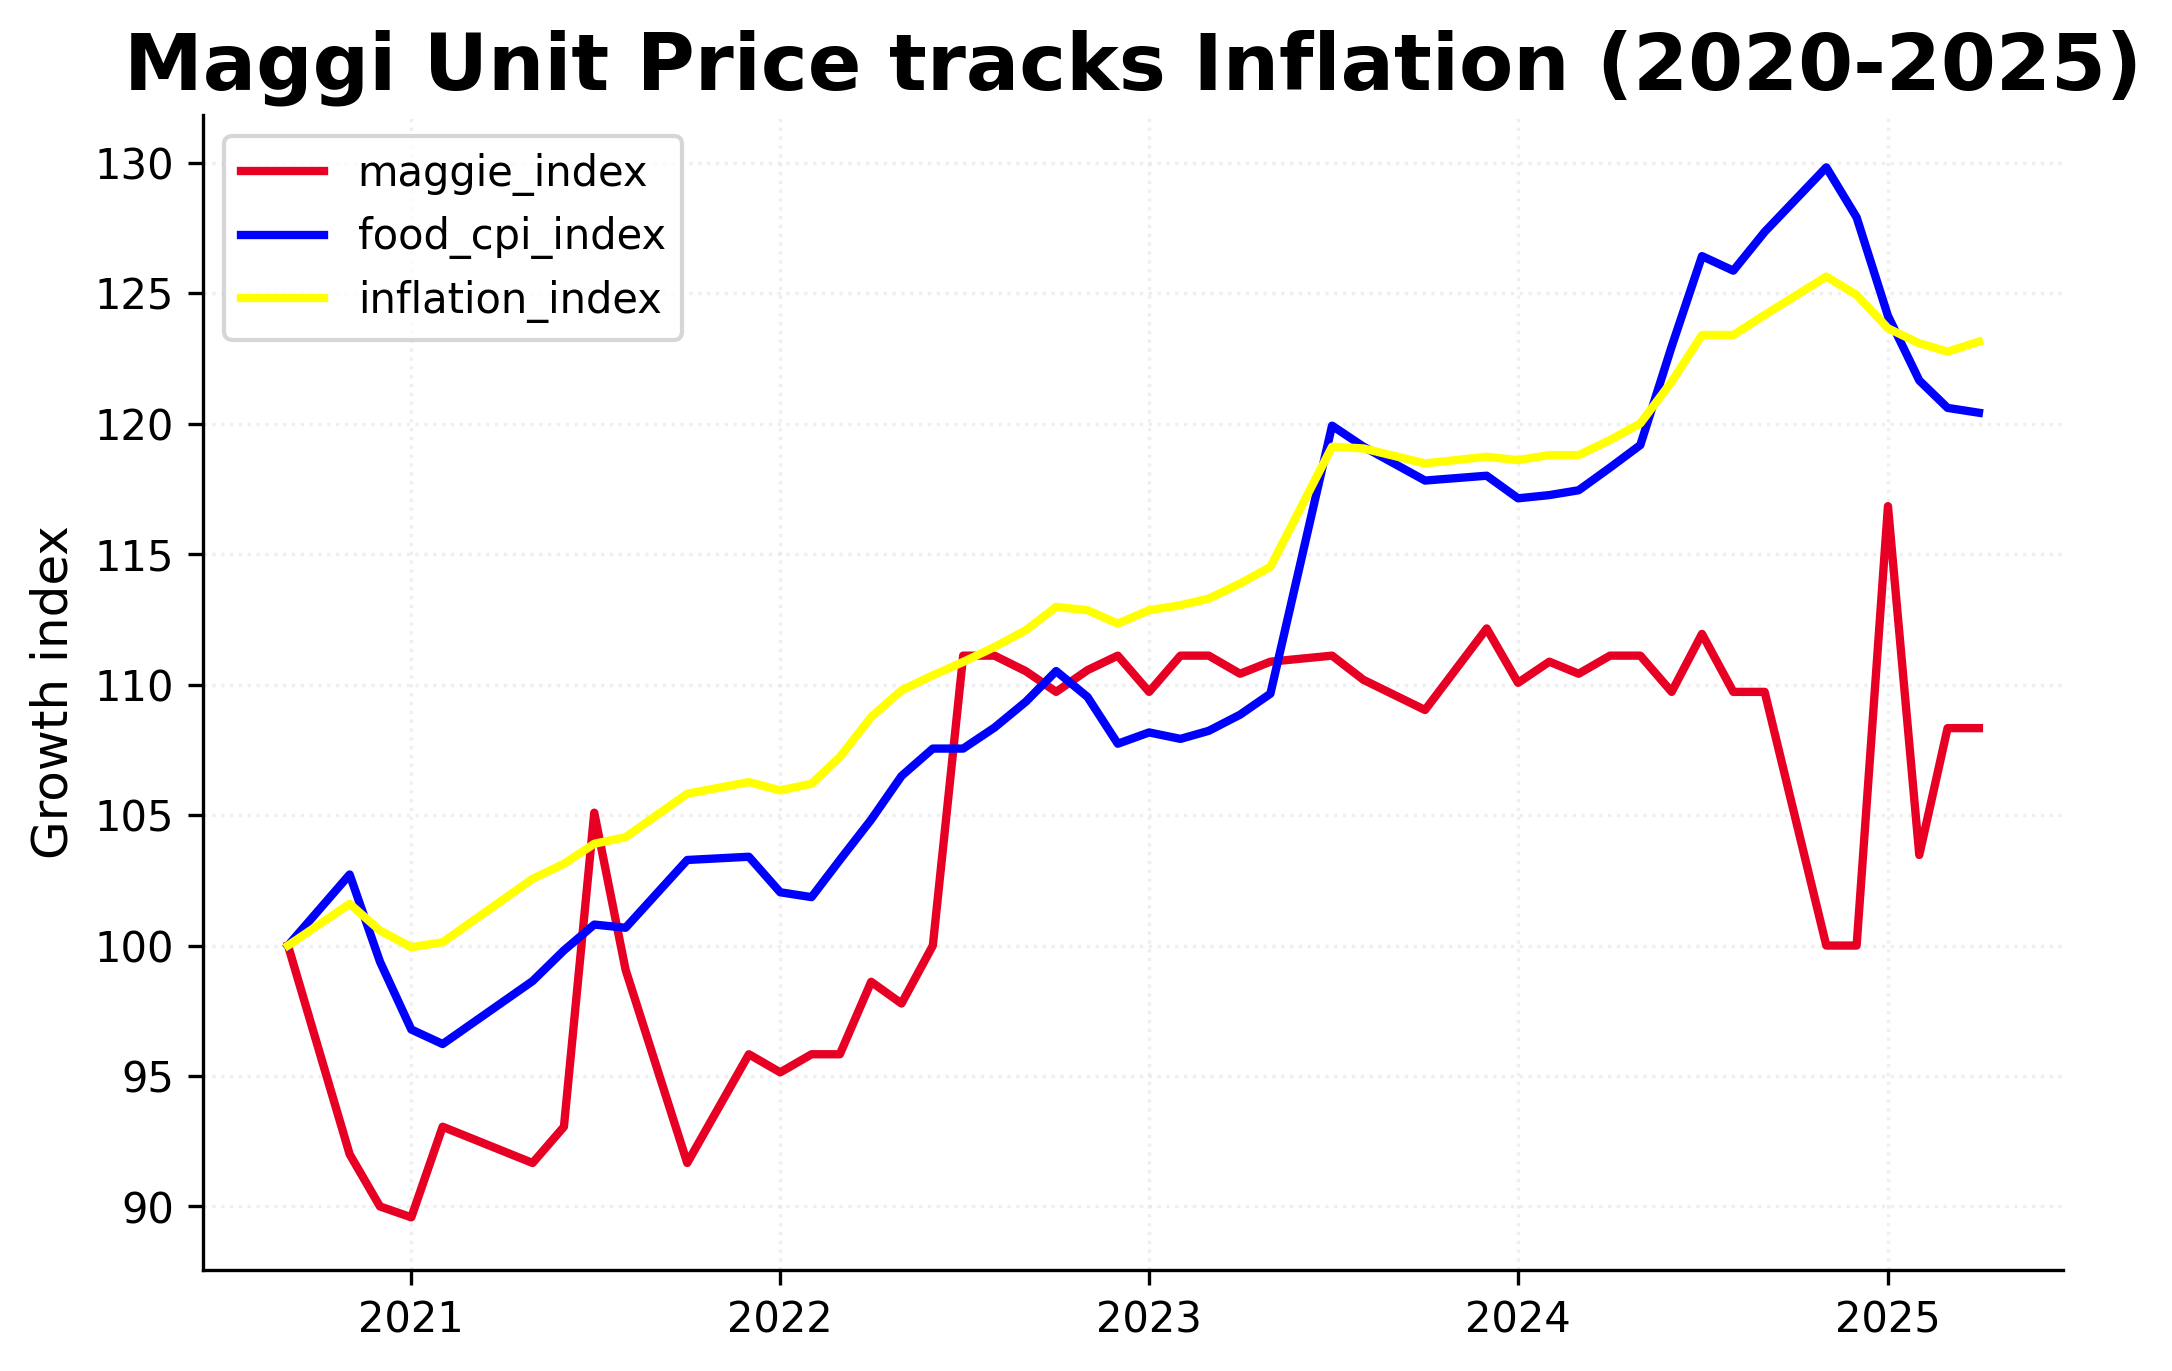

In [ ]:
# ploting the maggie price vs date graph

plt.figure(figsize=(8,5),dpi=300)

sns.lineplot(final_df,
             x='date',
             y='maggie_index',
             color='#E70023',
             lw=2,
             label='maggie_index'
             )

sns.lineplot(final_df,
             x='date',
             y='food_cpi_index',
             color='blue',
             lw=2,
             label='food_cpi_index'
             )

sns.lineplot(final_df,
             x='date',
             y='inflation_index',
             color='yellow',
             lw=2,
             label='inflation_index'
             )
plt.xlabel('')
plt.ylabel('Growth index',fontsize=12)
plt.grid(True,alpha=0.5,color='#e0e0e0',ls='dotted')
plt.title('Maggi Unit Price tracks Inflation (2020-2025)',fontsize=19,fontweight='bold')
sns.despine()
plt.savefig('Maggie unit price tracks inflation(2020-2025)',bbox_inches='tight')